In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25,15

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())
from tensorflow import GPUOptions, Session, ConfigProto

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

gpu_options = GPUOptions(per_process_gpu_memory_fraction = 0.7)       #Assign portion of memory for training this model
sess = Session(config = ConfigProto(gpu_options = gpu_options))

c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

In [2]:
df = pd.read_csv('E:\BitCoin Prediction\BTC-USD.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-17,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-18,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-19,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-20,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-21,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [4]:
df.dropna(inplace = True)

data = df.drop(['Open','High','Low','Adj Close','Volume'], axis = 1)

In [5]:
data.Date = pd.to_datetime(data.Date, format = '%Y-%m-%d')

In [6]:
data.index = data.Date

In [7]:
data.drop(['Date'], axis = 1, inplace = True)
data.head()

,Close
Date,
2010-07-17,0.04951
2010-07-18,0.08584
2010-07-19,0.08080
2010-07-20,0.07474
2010-07-21,0.07921


In [8]:
dataset = data.values

In [9]:
dataset.shape

(3354, 1)

In [10]:
train = dataset[:3000]
valid = dataset[3000:]

dataset = scaler.fit_transform(dataset)

In [11]:
X_train, y_train = [],[]
for i in range(120,len(train)):
    X_train.append(dataset[i-120:i])
    y_train.append(dataset[i])
X_train, y_train = np.array(X_train),np.array(y_train)

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM

In [13]:
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

In [14]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120, 100)          40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 50)           30200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 91,251
Trainable params: 91,251
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train,
         epochs = 1,
         verbose = 1)

W0924 20:44:47.784312 16944 deprecation_wrapper.py:119] From c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/1
2880/2880 [==============================] - 22s 7ms/step - loss: 0.0027


In [17]:
inputs = dataset[len(dataset)-len(valid)-120:]

In [18]:
inputs.shape

(474, 1)

In [19]:
x_test = []
for i in range(120,len(inputs)):
    x_test.append(inputs[i-120:i])
x_test = np.array(x_test)

In [20]:
price = model.predict(x_test)
price = scaler.inverse_transform(price)

In [21]:
import math
import statistics
error, accuracy = [],[]

for i in range(0,len(price)):
    err = math.sqrt(((valid[i]-price[i])/valid[i])**2)
    error.append(err)
    acc = 100 - err*100
    accuracy.append(acc)
    
mean_accuracy = statistics.mean(accuracy)

print(mean_accuracy)

92.35112052720436


In [22]:
training = data[1900:3000]
validation = data[3000:]
validation['Price'] = price

c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


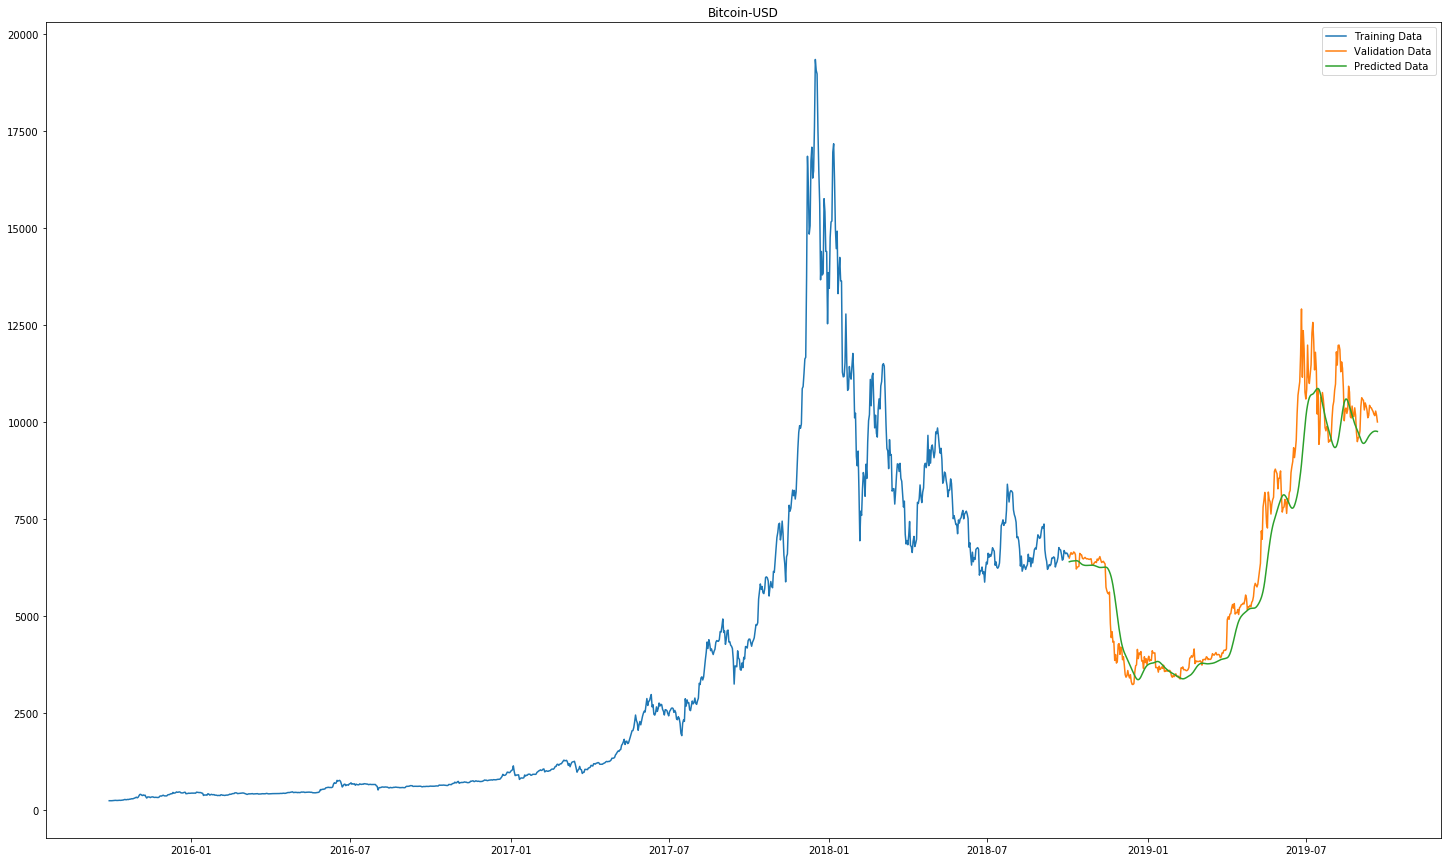

In [37]:
rcParams['figure.figsize'] = 25,15
plt.title('Bitcoin-USD')
plt.plot(training['Close'], label = "Training Data")
plt.plot(validation['Close'], label = "Validation Data")
plt.plot(validation['Price'], label = "Predicted Data")
plt.legend()
plt.show()

In [38]:
cnt = 0
new_prices = list(valid[-120:])
while(cnt!=10):
    test = np.array(new_prices[-120:])
    test = test.reshape(120,1)
    test = scaler.fit_transform(test)
    test = test.reshape(1,120,1)
    price = model.predict(test)
    price = scaler.inverse_transform(price)
    new_prices.append(price)
    cnt +=1

In [39]:
new_prices = np.array(new_prices)
new_prices = new_prices.reshape(len(new_prices))

In [40]:
tod = df['Date'].iloc[-1]

In [41]:
tod = pd.to_datetime(tod, format = '%Y-%m-%d')

In [42]:
prices = pd.date_range(tod, periods = 10)

In [43]:
new_frame = pd.DataFrame(columns=['Dates','Prices'])
new_frame = new_frame.fillna(0) # with 0s rather than NaNs

In [44]:
new_frame

,Dates,Prices


In [45]:
new_frame.Dates = prices

In [46]:
new_frame.Prices = new_prices[120:]

In [47]:
new_frame

,Dates,Prices
0,2019-09-21,10177.2
1,2019-09-22,10162.9
2,2019-09-23,10146.9
3,2019-09-24,10130.2
4,2019-09-25,10113.6
5,2019-09-26,10097.3
6,2019-09-27,10081.6
7,2019-09-28,10066.6
8,2019-09-29,10052.2
9,2019-09-30,10038.4


In [48]:
new_frame.index = new_frame.Dates

In [49]:
new_frame.drop('Dates',axis = 1,inplace = True)

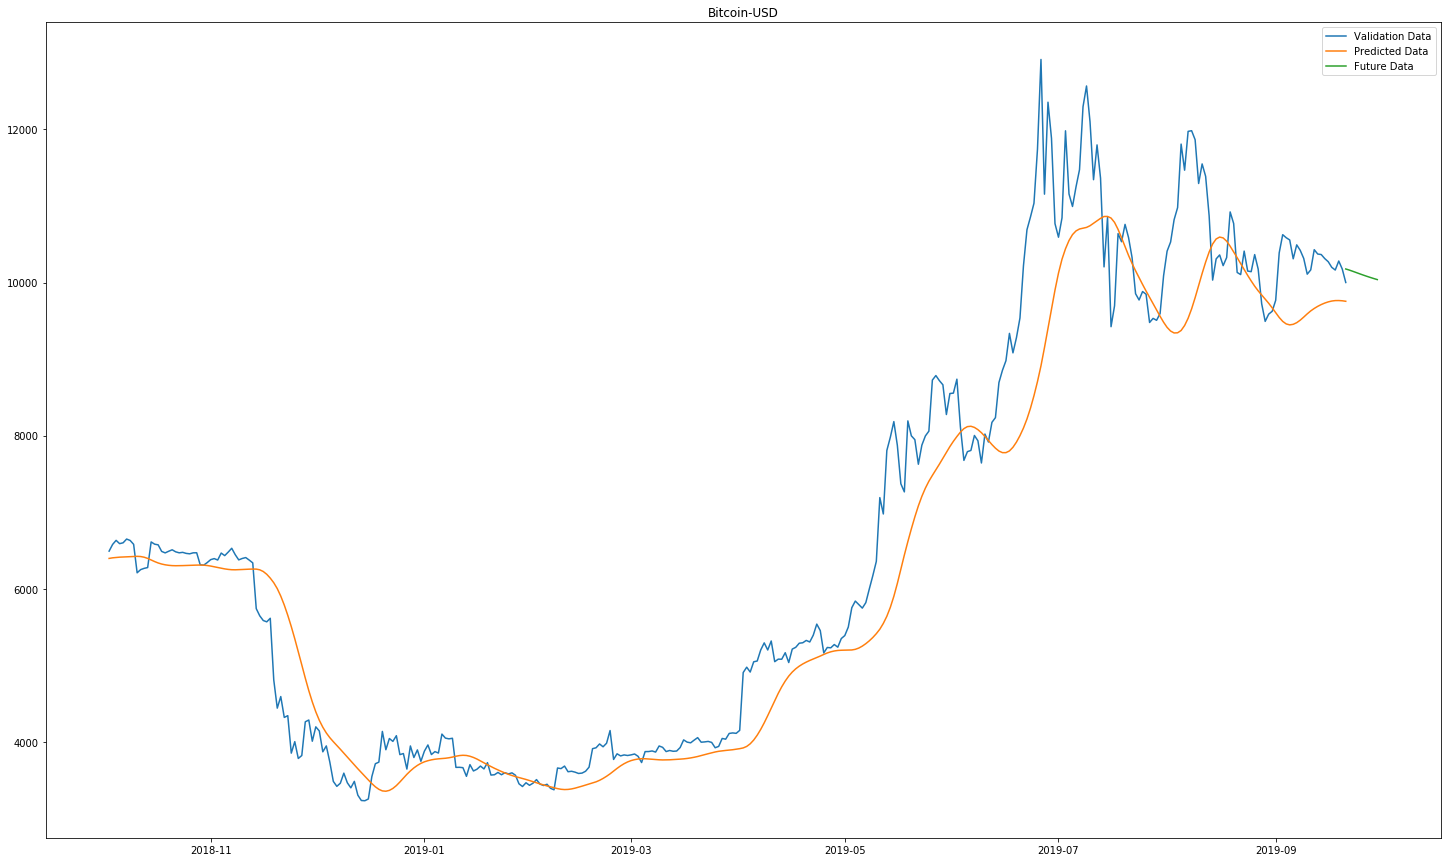

In [50]:
rcParams['figure.figsize'] = 25,15
plt.title('Bitcoin-USD')
#plt.plot(training['Close'], label = "Training Data")
plt.plot(validation['Close'], label = "Validation Data")
plt.plot(validation['Price'], label = "Predicted Data")
plt.plot(new_frame['Prices'], label = "Future Data")
plt.legend()